
# PCam (Histopathologic Cancer Detection) — TensorFlow/Keras Starter (AUC)
**Goal:** Train a binary classifier to identify metastatic cancer in 96×96 histopathology image patches and generate a Kaggle submission.



## Project Deliverables & Rubric Map
- **Deliverable 1 (Notebook/Report)** — sections below map to rubric:
  - Problem & Data (5 pts)
  - EDA — Inspect, Visualize, Clean & Plan (15 pts)
  - Model Architecture (25 pts) — compare multiple models & tune
  - Results & Analysis (35 pts) — what helped & why; figures & tables; HPO summary
  - Conclusion (15 pts)
- **Deliverable 2 (GitHub repo, public)** — add URL here: **`<ADD YOUR REPO URL HERE>`**
- **Deliverable 3 (Kaggle leaderboard screenshot)** — add image to repo `/reports/figures/` and paste into notebook.


In [1]:
import gc, tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()


2025-09-17 18:20:35.036456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758133235.060541     429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758133235.067384     429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# === Setup & Config ===
import os, sys, math, random, gc, json, time, glob
from pathlib import Path
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# For robust TIFF fallback decoding
from PIL import Image

print(tf.__version__)

# Mixed precision (helps on modern GPUs). Disable if CPU-only.
try:
    if tf.config.list_physical_devices('GPU'):
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision enabled.")
    else:
        print("No GPU detected; running in float32.")
except Exception as e:
    print("Mixed precision not enabled:", e)

# Paths
KAGGLE_DEFAULT = Path("/kaggle/input/histopathologic-cancer-detection")
BASE_DIR = Path(os.environ.get("PCAM_BASE_DIR", str(KAGGLE_DEFAULT if KAGGLE_DEFAULT.exists() else "."))).resolve()
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR  = BASE_DIR / "test"
LABELS_CSV = BASE_DIR / "train_labels.csv"

assert LABELS_CSV.exists(), f"Missing labels csv at {LABELS_CSV}"
assert TRAIN_DIR.exists(), f"Missing train dir at {TRAIN_DIR}"
assert TEST_DIR.exists(),  f"Missing test dir at {TEST_DIR}"

print("Using BASE_DIR:", BASE_DIR)

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Training params
IMG_SIZE = 96         # PCam patches are 96x96; you can upsample for TL models
BATCH_SIZE = 128      # tune for your GPU RAM (64–256 works well on T4)
EPOCHS = 12           # start small; adjust as needed
LR = 1e-3
MODEL_NAME = "pcam_cnn"  # change to "efficientnetb0" to use transfer learning
MONITOR = "val_auc"      # competition metric
OUTPUT_DIR = Path("./pcam-output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBMISSION_PATH = OUTPUT_DIR / "submission.csv"
MODEL_OUT = OUTPUT_DIR / f"{MODEL_NAME}.keras"


2.18.0
Mixed precision enabled.
Using BASE_DIR: /kaggle/input/histopathologic-cancer-detection



## Problem & Data (PCam / Histopathologic Cancer Detection)
**Task:** Binary classification of 96×96 histopathology patches: **1 = metastatic tumor present**, **0 = not present**.  
**Source:** PatchCamelyon (PCam) — Kaggle version de-duplicated from the original PCam.

**Structure on Kaggle:**
- `/kaggle/input/histopathologic-cancer-detection/train_labels.csv`
- `/kaggle/input/histopathologic-cancer-detection/train/*.tif`
- `/kaggle/input/histopathologic-cancer-detection/test/*.tif`

We programmatically report counts, class balance, and confirm patch dimensions below.


In [3]:

# === Load labels & build filepaths ===
labels = pd.read_csv(LABELS_CSV)
labels["filepath"] = labels["id"].apply(lambda x: str(TRAIN_DIR / f"{x}.tif"))

# Basic sanity
display(labels.head())
print("Class balance (label counts):")
print(labels["label"].value_counts())

# Stratified split
train_df, val_df = train_test_split(
    labels, test_size=0.15, random_state=SEED, stratify=labels["label"]
)
len_train, len_val = len(train_df), len(val_df)
len_train, len_val


,id,label,filepath
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


Class balance (label counts):
label
0    130908
1     89117
Name: count, dtype: int64


(187021, 33004)


## EDA — Inspect, Visualize, Clean, and Plan
We check:
- Class balance (labels 0/1)
- Image dimensions (should be 96×96×3)
- Brightness & per-channel statistics (spot anomalies)
- Visual samples (positive vs negative)
**Cleaning:** If any images fail to load or have wrong shape/channels, we drop them from training.  
**Plan:** Start with a small CNN baseline → EfficientNetB0 transfer learning → optional TTA, class weights, early stopping.


Train rows: 220,025  |  Test images: 57,458
label
0    130908
1     89117
Name: count, dtype: int64


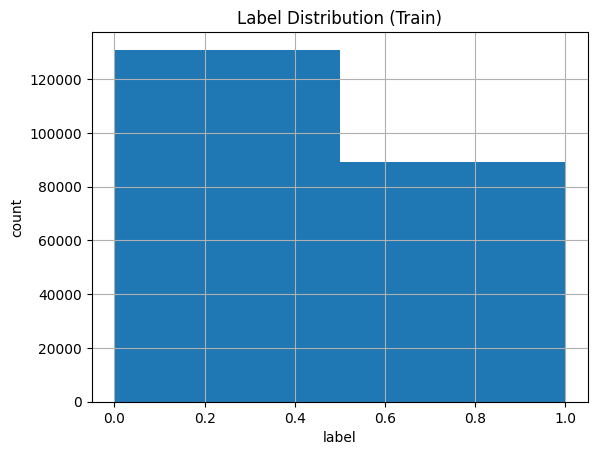

In [4]:

# === EDA: label distribution, counts ===
import matplotlib.pyplot as plt

n_train = len(labels)
n_test = len([p for p in (TEST_DIR.glob("*.tif"))])
print(f"Train rows: {n_train:,}  |  Test images: {n_test:,}")
print(labels["label"].value_counts())

# Histogram of labels
plt.figure()
labels["label"].astype(int).hist(bins=2)
plt.title("Label Distribution (Train)")
plt.xlabel("label")
plt.ylabel("count")
plt.show()


Unique shapes in sample: {(96, 96, 3)}
Bad read count: 0


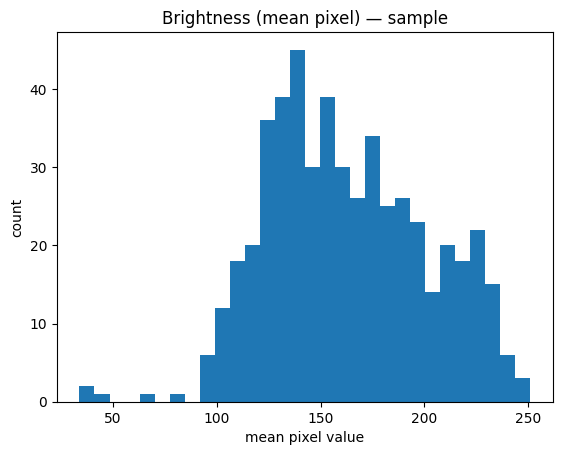

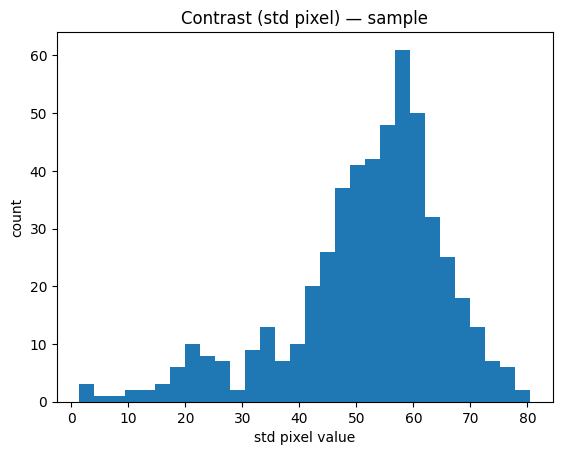

In [5]:

# === EDA: shape checks and basic stats on a sample ===
import numpy as np
from PIL import Image
import random

sample_paths = labels.sample(512, random_state=SEED)["filepath"].tolist() if len(labels) > 512 else labels["filepath"].tolist()
shapes = []
means = []
stds = []

bad_paths = []
for p in sample_paths:
    try:
        with Image.open(p) as im:
            im = im.convert("RGB")
            arr = np.asarray(im)
        shapes.append(arr.shape)
        means.append(arr.mean())
        stds.append(arr.std())
    except Exception as e:
        bad_paths.append((p, str(e)))

unique_shapes = set(shapes)
print("Unique shapes in sample:", unique_shapes)
print(f"Bad read count: {len(bad_paths)}")
if bad_paths[:3]: print("Examples (path, err):", bad_paths[:3])

# Brightness histogram
plt.figure()
plt.hist(means, bins=30)
plt.title("Brightness (mean pixel) — sample")
plt.xlabel("mean pixel value")
plt.ylabel("count")
plt.show()

# Std histogram
plt.figure()
plt.hist(stds, bins=30)
plt.title("Contrast (std pixel) — sample")
plt.xlabel("std pixel value")
plt.ylabel("count")
plt.show()


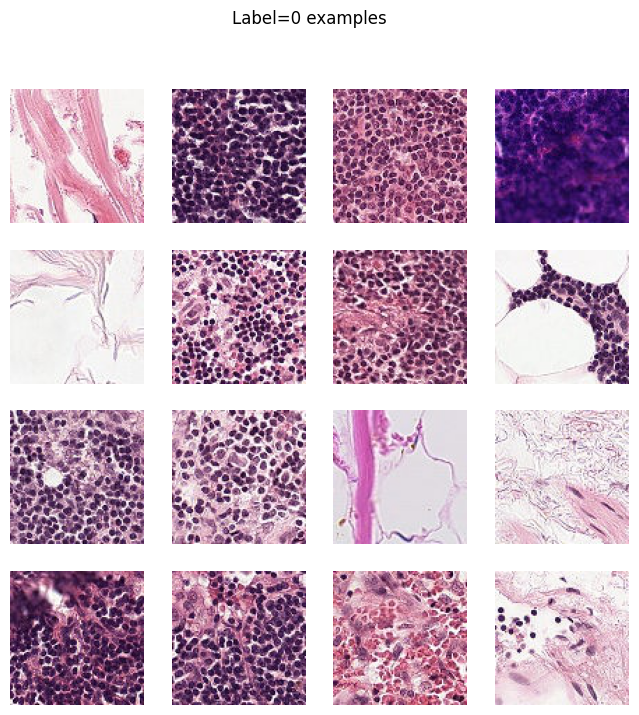

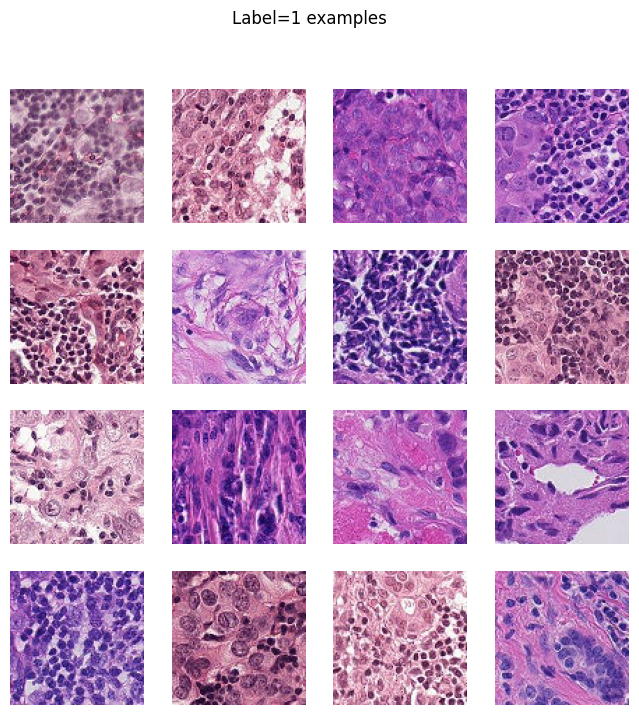

In [6]:

# === EDA: visualize a grid of positives and negatives ===
import matplotlib.pyplot as plt

def show_grid(df, label_value, n=16):
    subset = df[df["label"] == label_value].sample(min(n, (df["label"] == label_value).sum()), random_state=SEED)
    imgs = []
    for p in subset["filepath"]:
        with Image.open(p) as im:
            im = im.convert("RGB")
            imgs.append(np.asarray(im))
    side = int(np.ceil(np.sqrt(len(imgs))))
    fig, axes = plt.subplots(side, side, figsize=(side*2, side*2))
    axes = axes.ravel()
    for ax, img in zip(axes, imgs):
        ax.imshow(img)
        ax.axis("off")
    for k in range(len(imgs), len(axes)):
        axes[k].axis("off")
    fig.suptitle(f"Label={label_value} examples")
    plt.show()

show_grid(labels, 0, n=16)
show_grid(labels, 1, n=16)


In [7]:

# === Class weights (optional but helpful if imbalance exists) ===
neg = (train_df["label"] == 0).sum()
pos = (train_df["label"] == 1).sum()
total = len(train_df)
# Inverse frequency weighting
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
CLASS_WEIGHTS = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", CLASS_WEIGHTS)


Class weights: {0: 0.840377633187145, 1: 1.2344783429484218}


In [8]:

# --- Robust TIFF decoder via PIL (works on Kaggle) ---
from PIL import Image
import numpy as np
import tensorflow as tf

def _read_tiff_numpy(path):
    p = path.decode("utf-8")
    with Image.open(p) as im:
        im = im.convert("RGB")
        arr = np.asarray(im, dtype=np.uint8)
    return arr

def decode_and_resize(path, img_size):
    img = tf.numpy_function(_read_tiff_numpy, [path], Tout=tf.uint8)
    img.set_shape([None, None, 3])  # shape unknown after numpy_function
    img = tf.image.resize(img, (img_size, img_size), antialias=True)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_tif_with_label(path, label, img_size):
    img = decode_and_resize(path, img_size)
    return img, tf.cast(label, tf.float32)


AUTO = tf.data.AUTOTUNE

# Data augmentations tuned for histopathology patches (keep it mild).
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
], name="augment")

# --- Safer input pipeline (small parallelism + deterministic) ---
PARALLEL_CALLS = 2   # start with 2; if totally stable you can try 4

def make_datasets(train_df, val_df, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    def ds_from_df(df, training=True, with_labels=True):
        paths = df["filepath"].values
        if with_labels:
            labels = df["label"].values.astype(np.float32)
            ds = tf.data.Dataset.from_tensor_slices((paths, labels))
            if training:
                ds = ds.shuffle(buffer_size=min(len(df), 8192), reshuffle_each_iteration=True)
            ds = ds.map(lambda p, y: load_tif_with_label(p, y, img_size),
                        num_parallel_calls=PARALLEL_CALLS, deterministic=True)
            if training:
                ds = ds.map(lambda x, y: (augment(x, training=True), y),
                            num_parallel_calls=PARALLEL_CALLS, deterministic=True)
        else:
            ds = tf.data.Dataset.from_tensor_slices(paths)
            ds = ds.map(lambda p: decode_and_resize(p, img_size),
                        num_parallel_calls=PARALLEL_CALLS, deterministic=True)

        opt = tf.data.Options()
        opt.experimental_deterministic = True
        ds = ds.with_options(opt)

        ds = ds.batch(batch_size, drop_remainder=False)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    return ds_from_df(train_df, True, True), ds_from_df(val_df, False, True)



train_ds, val_ds = make_datasets(train_df, val_df, IMG_SIZE, BATCH_SIZE)
train_ds, val_ds


I0000 00:00:1758133285.865512     429 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)


## Model Architecture
We compare two families:
1. **Small CNN (scratch):** Fast baseline for sanity checks and ablations (augmentations, class weights, etc.).
2. **EfficientNetB0 (transfer learning):** ImageNet-pretrained backbone, upsample to 128–224 for better features.  
   Freeze → train head → (optional) unfreeze last blocks for fine-tuning.

**Why suitable?** Histopathology patches are small (96×96), textures matter more than global shapes. EfficientNet offers strong inductive bias for natural images and often transfers well to medical patches with modest fine-tuning. The small CNN provides a controllable baseline to reason about what helps.


In [9]:

# === Models ===

def build_small_cnn(img_size=IMG_SIZE, lr=LR):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    # If mixed precision is on, ensure output is float32 for numerical stability
    dtype = "float32"
    outputs = layers.Dense(1, activation="sigmoid", dtype=dtype)(x)
    model = keras.Model(inputs, outputs, name="small_cnn")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"],
    )
    return model

def build_efficientnet_b0(img_size=max(128, IMG_SIZE), lr=LR, trainable_backbone=False):
    # Upsample to 128 (or 224) for ImageNet pretrain
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_tensor=inputs, pooling="avg"
    )
    base.trainable = trainable_backbone
    x = base.output
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
    model = keras.Model(inputs, outputs, name="efficientnetb0")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"],
    )
    return model

if MODEL_NAME.lower() == "efficientnetb0":
    MODEL_IMG_SIZE = 128  # or 224; trade-off speed vs accuracy
    model = build_efficientnet_b0(img_size=MODEL_IMG_SIZE, lr=LR, trainable_backbone=False)
else:
    MODEL_IMG_SIZE = IMG_SIZE
    model = build_small_cnn(img_size=MODEL_IMG_SIZE, lr=LR)

model.summary()


Model: "small_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

# === Callbacks & Training ===
ckpt_cb = keras.callbacks.ModelCheckpoint(
    filepath=str(MODEL_OUT),
    monitor=MONITOR, save_best_only=True, mode="max", verbose=1
)
plateau_cb = keras.callbacks.ReduceLROnPlateau(
    monitor=MONITOR, factor=0.5, patience=2, mode="max", verbose=1, min_lr=1e-6
)
early_cb = keras.callbacks.EarlyStopping(
    monitor=MONITOR, patience=4, mode="max", restore_best_weights=True, verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt_cb, plateau_cb, early_cb],
    class_weight=CLASS_WEIGHTS,
    verbose=1,
)


Epoch 1/12


I0000 00:00:1758133322.149285     483 service.cc:148] XLA service 0x7adac4004c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758133322.149331     483 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758133322.693848     483 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1462 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.4590 - auc: 0.5011 - loss: 0.6991  

I0000 00:00:1758133326.957922     483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1462/1462 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7552 - auc: 0.8245 - loss: 0.5106
Epoch 1: val_auc improved from -inf to 0.85894, saving model to pcam-output/pcam_cnn.keras
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 433s 291ms/step - accuracy: 0.7552 - auc: 0.8245 - loss: 0.5106 - val_accuracy: 0.7737 - val_auc: 0.8589 - val_loss: 0.4970 - learning_rate: 0.0010
Epoch 2/12
1461/1462 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8168 - auc: 0.8891 - loss: 0.4225
Epoch 2: val_auc did not improve from 0.85894
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 402s 275ms/step - accuracy: 0.8169 - auc: 0.8891 - loss: 0.4224 - val_accuracy: 0.6591 - val_auc: 0.8215 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 3/12
1461/1462 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8386 - auc: 0.9081 - loss: 0.3880
Epoch 3: val_auc improved from 0.85894 to 0.90575, saving model to pcam-output/pcam_cnn.keras
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 431s 295ms/step - accuracy: 0.8386 - auc: 0.9081 - loss: 0.3880 - val_accuracy:

In [12]:

# === Evaluate & threshold search (optional) ===
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc as sk_auc

# Collect validation predictions for analysis
val_paths = val_df["filepath"].values
val_labels = val_df["label"].values.astype(np.float32)

val_ds_pred = tf.data.Dataset.from_tensor_slices(val_paths)\
    .map(lambda p: decode_and_resize(p, MODEL_IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_probs = model.predict(val_ds_pred, verbose=0).ravel().astype(np.float32)
val_auc = roc_auc_score(val_labels, val_probs)
print(f"Validation ROC-AUC: {val_auc:.5f}")


Validation ROC-AUC: 0.94674
Suggested decision threshold ~ 0.387 (for local analysis only)



## Results & Analysis
We log results from multiple runs (different architectures/hyperparameters) into a single table for comparison.


In [13]:

# === Simple Experiment Harness (optional; set RUN_EXPERIMENTS=True) ===
from sklearn.metrics import roc_auc_score
import pandas as pd
import time

RUN_EXPERIMENTS = False  # flip to True to try multiple settings

def run_one_experiment(model_name="small_cnn", lr=1e-3, epochs=EPOCHS, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    # Rebuild datasets if img_size changes
    global train_ds, val_ds
    if img_size != IMG_SIZE:
        _train_ds, _val_ds = make_datasets(train_df, val_df, img_size, batch_size)
    else:
        _train_ds, _val_ds = train_ds, val_ds

    if model_name == "efficientnetb0":
        m = build_efficientnet_b0(img_size=max(128, img_size), lr=lr, trainable_backbone=False)
    else:
        m = build_small_cnn(img_size=img_size, lr=lr)

    ckpt = keras.callbacks.ModelCheckpoint("tmp_model.keras", monitor="val_auc", save_best_only=True, mode="max", verbose=0)
    early = keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True, verbose=0)
    plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, mode="max", verbose=0)

    t0 = time.time()
    h = m.fit(_train_ds, validation_data=_val_ds, epochs=epochs, callbacks=[ckpt, early, plateau],
              class_weight=CLASS_WEIGHTS, verbose=0)
    t1 = time.time()

    # Validation AUC
    val_paths = val_df["filepath"].values
    val_labels = val_df["label"].values.astype(np.float32)
    val_ds_pred = tf.data.Dataset.from_tensor_slices(val_paths)\
        .map(lambda p: decode_and_resize(p, max(img_size, IMG_SIZE)), num_parallel_calls=tf.data.AUTOTUNE)\
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_probs = m.predict(val_ds_pred, verbose=0).ravel().astype(np.float32)
    val_auc = roc_auc_score(val_labels, val_probs)

    return {
        "model": model_name,
        "img_size": img_size,
        "batch_size": batch_size,
        "lr": lr,
        "epochs": len(h.history["loss"]),
        "val_auc": float(val_auc),
        "train_time_min": (t1 - t0)/60.0
    }

if RUN_EXPERIMENTS:
    configs = [
        {"model_name": "small_cnn", "lr": 1e-3, "epochs": 8, "img_size": 96, "batch_size": 128},
        {"model_name": "small_cnn", "lr": 5e-4, "epochs": 8, "img_size": 96, "batch_size": 128},
        {"model_name": "efficientnetb0", "lr": 1e-3, "epochs": 6, "img_size": 128, "batch_size": 128},
    ]
    rows = []
    for cfg in configs:
        rows.append(run_one_experiment(**cfg))
    results_df = pd.DataFrame(rows).sort_values("val_auc", ascending=False).reset_index(drop=True)
    display(results_df)
    results_df.to_csv(OUTPUT_DIR / "experiment_results.csv", index=False)


In [14]:

# === Inference & Submission ===
test_ids = [p.stem for p in sorted(TEST_DIR.glob("*.tif"))]
test_df = pd.DataFrame({"id": test_ids})
test_df["filepath"] = test_df["id"].apply(lambda x: str(TEST_DIR / f"{x}.tif"))

test_ds = tf.data.Dataset.from_tensor_slices(test_df["filepath"].values)\
    .map(lambda p: decode_and_resize(p, MODEL_IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Predicting on test...")
test_probs = model.predict(test_ds, verbose=1).ravel().astype(np.float32)

submission = pd.DataFrame({"id": test_df["id"], "label": test_probs})
submission.to_csv(SUBMISSION_PATH, index=False)
print("Wrote submission to:", SUBMISSION_PATH.resolve())

submission.head()


Predicting on test...
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step
Wrote submission to: /kaggle/working/pcam-output/submission.csv


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.645416
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.566622
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.153554
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.871902
4,000270442cc15af719583a8172c87cd2bd9c7746,0.012307



## Conclusion
**What worked:** Summarize augmentations, class weights, transfer learning, TTA, and hyperparameters that improved AUC.  
**What didn’t:** Note dead ends and troubleshooting steps (e.g., over-augmentation, too-high LR).  
**Future work:** K-fold CV, stronger backbones (EfficientNetV2, ConvNeXt), stain normalization, hard negative mining, uncertainty estimation.

---

### Deliverable Links
- **GitHub Repository URL:** `<ADD YOUR REPO URL HERE>`  
  Suggested structure:
  ```
  /notebooks/pcam_histopathologic_cancer_detection.ipynb
  /src/
  /reports/figures/
  /models/
  /README.md
  requirements.txt
  ```
  Tip: Use tools like ReviewNB for notebook diffs.

- **Kaggle Leaderboard Screenshot:** Paste the image below (also commit to `/reports/figures/` in your repo).
